In [2]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import random
import tensorflow as tf
from keras.metrics import MeanIoU
import segmentation_models as sm
from keras.callbacks import ModelCheckpoint, EarlyStopping,  CSVLogger

from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import segmentation_models as sm

import albumentations as A

from tensorflow.keras.optimizers import Adam

from datetime import datetime 

from PIL import Image
from keras import backend, optimizers

from focal_loss import BinaryFocalLoss
from att_models import Attention_ResUNet, UNet, Attention_UNet, dice_coef, dice_coef_loss, jacard_coef


Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [3]:
def display_multiple_img(hill, original, ground_truth, y_test_argmax, plt_name, save_results, n=5):
    figure, ax = plt.subplots(nrows=n, ncols=4,figsize=(12,n*5) )
    c=0
    j=1
    for i in range(n):
        image_number = random.randint(0, len(ground_truth)-1)
        ax.ravel()[c].imshow(original[image_number], cmap='gray')
        ax.ravel()[c].set_title("Hillshade Image: "+str(image_number))
        ax.ravel()[c+1].imshow(ground_truth[image_number], cmap='gray')
        ax.ravel()[c+1].set_title("Ground Truth: "+str(image_number))
        ax.ravel()[c+2].imshow(y_test_argmax[image_number], cmap='gray')
        ax.ravel()[c+2].set_title("Predicted Image: "+str(image_number))
        
        ax.ravel()[c+3].imshow(hill[image_number], cmap='gray')
        ax.ravel()[c+3].set_title("Hillshade Image: "+str(image_number))
        
        c=c+4
        j=j+1
    plt.tight_layout()
    plt.savefig(save_results+"/"+str(plt_name)+".png")
    plt.show()
    
def display_learning_curves(history):
    result = history.history
    param=[]
    for key in result:
        param.append(key)
    l = int(len(result)/2)  
    print(l)
    n_epochs = range(1, len(history.history[param[0]]) + 1)
    print(n_epochs)


    fig = plt.figure(figsize=(12,6))
        
    plt.subplot(1,3,1)
    plt.plot(n_epochs, history.history[param[0]], label=str(param[0]))
    plt.plot(n_epochs, history.history[param[0+l]], label=str(param[0+l]))
    plt.title(str(param[0]))
    plt.xlabel("Epoch")
    plt.ylabel(str(param[0]))
    plt.legend(loc="upper right")
    
    plt.subplot(1,3,2)
    plt.plot(n_epochs, history.history[param[1]], label=str(param[1]))
    plt.plot(n_epochs, history.history[param[1+l]], label=str(param[1+l]))
    plt.title(str(param[1]))
    plt.xlabel("Epoch")
    plt.ylabel(str(param[1]))
    plt.legend(loc="upper right")

    plt.subplot(1,3,3)
    plt.plot(n_epochs, history.history[param[2]], label=str(param[2]))
    plt.plot(n_epochs, history.history[param[2+l]], label=str(param[2+l]))
    plt.title(str(param[2]))
    plt.xlabel("Epoch")
    plt.ylabel(str(param[2]))
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()


def get_rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label = label

    label_seg = np.zeros(label.shape,dtype=np.float32)
    #when platforms
#     label_seg [np.all(label>=150,axis=-1)] = 1
#     label_seg [np.all(label<150,axis=-1)] = 0
    #when annular structure
    
    label_seg [np.all(label>=254,axis=-1)] = 1
    label_seg [np.all(label<254,axis=-1)] = 0
    
    return label_seg

def get_labels_from_mask(mask_dataset):
    
    labels = []
    for i in range(len(mask_dataset)):
        label = get_rgb_to_2D_label(mask_dataset[i])
        labels.append(label)    
    labels = np.array(labels)
    return labels

def get_area_covered(img, th_area=2):

    height = img.shape[0]
    width = img.shape[1]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,1,cv2.THRESH_BINARY)
    count = cv2.countNonZero(thresh)
    area = (1- count/(width*height))*100
    if area >th_area:
        return True
    else:
        return False
    
def get_column(mask, i):
    col = [row[i] for row in mask]
    col = np.array(col)
    col = np.hstack(col.flatten()) 
    if 0 in col:
        return True
    else: 
        return False
def get_row(mask, i):    
    row = np.array(mask[i])
    row = np.hstack(row.flatten())
    if 0 in row:
        return True
    else: 
        return False 
    
def check_if_obj_border(mask):
    x, y, z = mask.shape
    #checking first and last row 
    row_f = get_row(mask, 0)
    row_l = get_row(mask, y-1)
    #checking first and last column 
    col_f = get_column(mask, 0)
    col_l = get_column(mask, y-1)
    op = [row_f, row_l, col_f, col_l]
    if True in op:
        return True
    
    else:
        return False

def get_image_mask_patches(img_dir, mask_dir, hill_dir, img_size=128, step=20, th_area=2):
    
    large_image_stack = cv2.imread(img_dir)
    large_mask_stack = cv2.imread(mask_dir)[:,:,0:1]
    large_hill_stack = cv2.imread(hill_dir)
    print(large_image_stack.shape)
    print(large_mask_stack.shape)
    print(large_hill_stack.shape)

    patches_img = patchify(large_image_stack, (img_size, img_size, 3), step=step)  #Step=128 for 128 patches means no overlap
   
    patches_mask = patchify(large_mask_stack, (img_size, img_size, 1), step=step)  #Step=128 for 128 patches means no overlap

    patches_hill = patchify(large_hill_stack, (img_size, img_size, 3), step=step)  #Step=128 for 128 patches means no overlap

    
    
    all_img_patches = []
    all_mask_patches = []
    all_hill_patches = []
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,0,:,:,:]

            single_patch_mask = (single_patch_mask.astype('float32'))
            single_patch_mask = get_labels_from_mask(single_patch_mask)
            #area_thresh = get_area_covered(single_patch_mask, th_area)
            #if len(np.unique(single_patch_mask))>1 and area_thresh:
            if len(np.unique(single_patch_mask))>1:
                check =check_if_obj_border(single_patch_mask[:,:,0:1])
                if check!=True:
                    all_mask_patches.append(single_patch_mask[:,:,0:1])   
                    
                    single_patch_img = patches_img[i,j,0,:,:,:]
                    single_patch_img = (single_patch_img.astype('float32')) / 255. 
                    all_img_patches.append(single_patch_img)
                    
                    single_patch_hill = patches_hill[i,j,0,:,:,:]
                    single_patch_hill = (single_patch_hill.astype('float32')) / 255. 
                    all_hill_patches.append(single_patch_hill)

    images = np.array(all_img_patches)
    masks = np.array(all_mask_patches) 
    hills = np.array(all_hill_patches) 
    
    return images, masks, hills



def get_sample_display_multiple_img(original, ground_truth, hillshade, n=5):
    figure, ax = plt.subplots(nrows=n, ncols=3,figsize=(12,n*5) )
    c=0
    j=1
    
    for i in range(n):
        image_number = random.randint(0, len(ground_truth)-1)
        ax.ravel()[c].imshow(original[image_number][:,:,0:1], cmap='gray')
        ax.ravel()[c].set_title("Original Image: "+str(image_number))
        ax.ravel()[c+1].imshow(ground_truth[image_number], cmap='gray')
        ax.ravel()[c+1].set_title("Ground Truth: "+str(image_number))
        ax.ravel()[c+2].imshow(hillshade[image_number], cmap='gray')
        ax.ravel()[c+2].set_title("Hillshade: "+str(image_number)) 
        c=c+3
        j=j+1
    plt.tight_layout()
    plt.show()


In [4]:
img_dir1 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/kom_dem.png'
mask_dir1 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/kom_as.png'
hill_dir1 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/kom_hill.png'

img_dir2 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/mls_dem.png'
mask_dir2 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/mls_as.png'
hill_dir2 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/mls_hill.png'

img_dir3 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/ucb_dem.png'
mask_dir3 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/ucb_as.png'
hill_dir3 = '/home/fjannat/Documents/EarthVision/data_resource/DEM/annular_structure/ucb_hill.png'

In [6]:
img1, mask1, hill1= get_image_mask_patches(img_dir1, mask_dir1, hill_dir1, img_size=128, step=40, th_area=1)
print(len(img1))

(5500, 3700, 3)
(5500, 3700, 1)
(5500, 3700, 3)
291


In [7]:
img2, mask2, hill2= get_image_mask_patches(img_dir2, mask_dir2, hill_dir2, img_size=128, step=40, th_area=1)
print(len(img2))

(4001, 6001, 3)
(4001, 6001, 1)
(4001, 6001, 3)
436


In [8]:
img3, mask3, hill3= get_image_mask_patches(img_dir3, mask_dir3, hill_dir3, img_size=128, step=20, th_area=1)
print(len(img3))

(1499, 2900, 3)
(1499, 2900, 1)
(1499, 2900, 3)
240


In [9]:
train_img = np.concatenate((img2, img3), axis=0)
train_mask = np.concatenate((mask2,mask3), axis=0)
train_hill = np.concatenate((hill2, hill3), axis=0)

val_img = img1
val_mask = mask1
val_hill = hill1

print(train_img.shape)
print(val_img.shape)

(676, 128, 128, 3)
(291, 128, 128, 3)


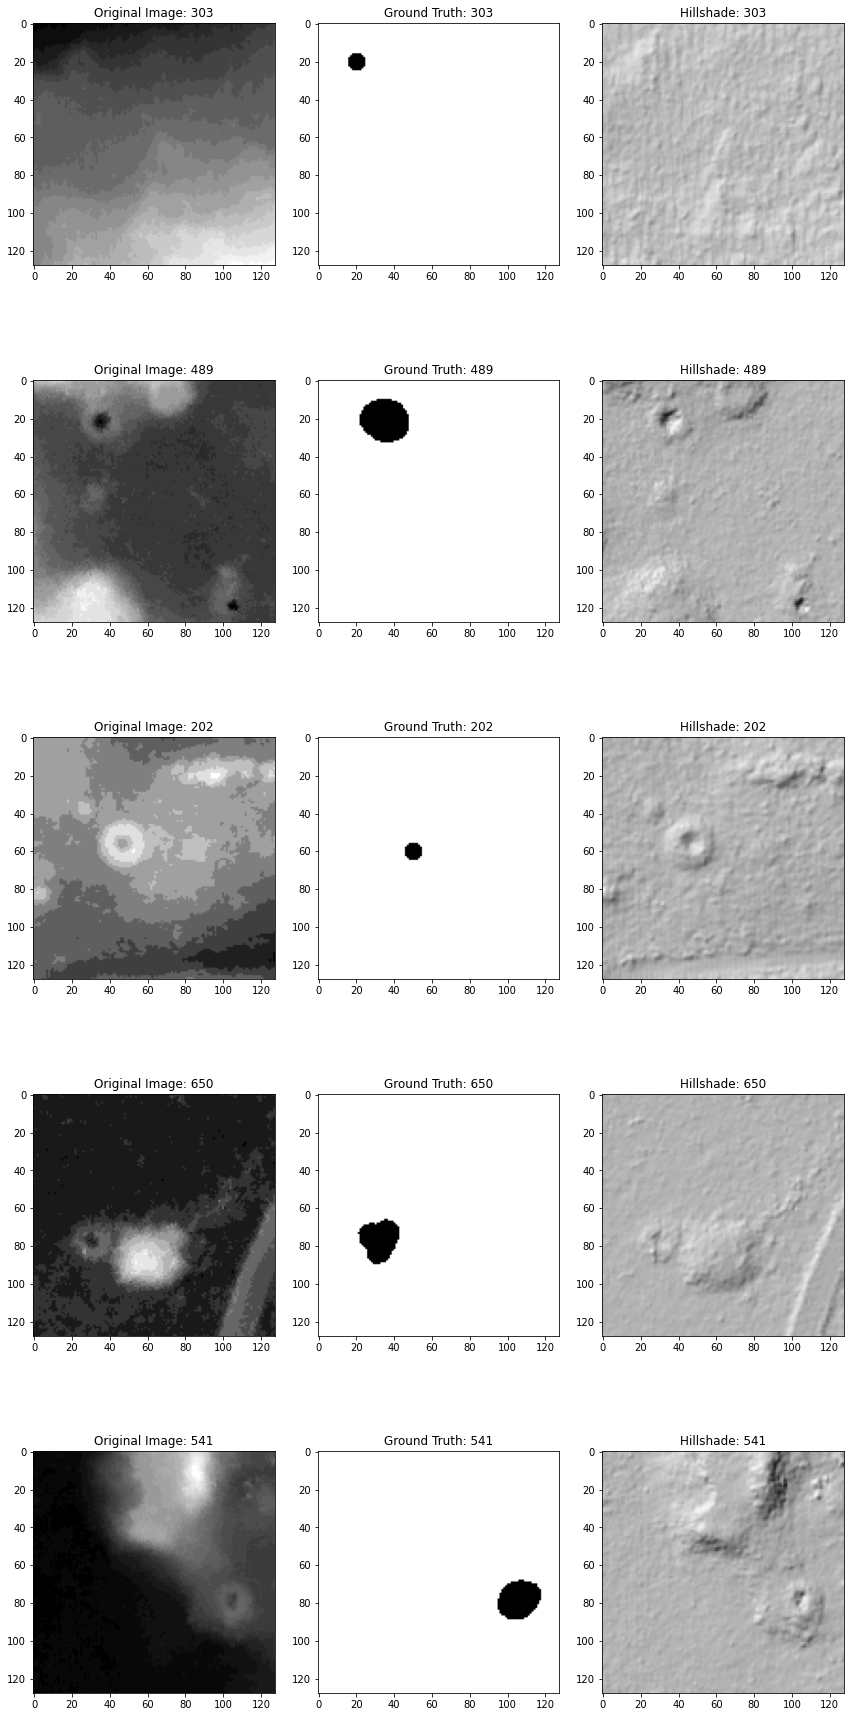

In [10]:
get_sample_display_multiple_img(train_img, train_mask, train_hill, n=5)

In [11]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_mask[:,:,:,0].shape
train_masks_reshaped = train_mask[:,:,:,0].reshape(-1,1)
print(train_masks_reshaped.shape)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))

n, h, w = val_mask[:,:,:,0].shape
val_masks_reshaped = val_mask[:,:,:,0].reshape(-1,1)
val_masks_reshaped_encoded = labelencoder.fit_transform(val_masks_reshaped)
val_masks_encoded_original_shape = val_masks_reshaped_encoded.reshape(n, h, w)
print(np.unique(val_masks_encoded_original_shape))


train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
val_masks_input = np.expand_dims(val_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

X_train = train_img
X_val = val_img

y_train = train_masks_input
y_val = val_masks_input
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

(11075584, 1)
[0 1]
[0 1]
(676, 128, 128, 1)
Class values in the dataset are ...  [0 1]


In [12]:
from tensorflow.keras.utils import to_categorical
n_classes=2

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))



In [13]:
X_train=np.expand_dims(X_train[:,:,:,1], axis=3)
X_val = np.expand_dims(X_val[:,:,:,1], axis=3)


In [14]:
#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
input_shape

(128, 128, 1)

In [20]:
BATCH_SIZE = 16
EPOCH =500


sm.set_framework('tf.keras')

sm.framework()

dice_loss = sm.losses.DiceLoss(class_weights=np.array([.5,.5])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [total_loss, sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


save_results='/home/fjannat/Documents/EarthVision/Results/annular_structure/dem/unet/trial_2'

if not os.path.exists(save_results):
    os.makedirs(save_results) 
    
    

checkpoint = ModelCheckpoint(save_results, monitor="val_iou_score", verbose=1, save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_iou_score", patience=150, verbose=1, mode="max")

# create list of callbacks
callbacks_list = [checkpoint, early_stopping]  # early_stopping

In [21]:


'''
UNet
'''
unet_model = UNet(input_shape, NUM_CLASSES=2)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.1), 
              metrics=metrics)


#print(unet_model.summary())

start1 = datetime.now() 
unet_history = unet_model.fit(X_train, y_train_cat, 
                    verbose=1,
                    batch_size = BATCH_SIZE,
                    validation_data=(X_val, y_val_cat ), 
                    shuffle=True,
                    epochs=EPOCH, 
                    callbacks=callbacks_list)

stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 128, 128, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 128, 128, 64) 0           batch_normalization_38[0][0]     
_______________________________________________________________________________________________

43/43 [==============================] - 17s 295ms/step - loss: 0.5485 - dice_loss_plus_1focal_loss: 0.8203 - iou_score: 0.4774 - f1-score: 0.4864 - val_loss: 81.6759 - val_dice_loss_plus_1focal_loss: 0.7917 - val_iou_score: 0.4901 - val_f1-score: 0.4950

Epoch 00001: val_iou_score improved from -inf to 0.49015, saving model to /home/fjannat/Documents/EarthVision/Results/annular_structure/dem/unet/trial_2
INFO:tensorflow:Assets written to: /home/fjannat/Documents/EarthVision/Results/annular_structure/dem/unet/trial_2/assets
Epoch 2/500
43/43 [==============================] - 12s 282ms/step - loss: 0.3557 - dice_loss_plus_1focal_loss: 0.7843 - iou_score: 0.4938 - f1-score: 0.4969 - val_loss: 0.3616 - val_dice_loss_plus_1focal_loss: 0.7895 - val_iou_score: 0.4770 - val_f1-score: 0.4876

Epoch 00002: val_iou_score did not improve from 0.49015
Epoch 3/500
43/43 [==============================] - 12s 283ms/step - loss: 0.2815 - dice_loss_plus_1focal_loss: 0.7705 - iou_score: 0.4938 - f1-sc

43/43 [==============================] - 12s 285ms/step - loss: 0.2117 - dice_loss_plus_1focal_loss: 0.7142 - iou_score: 0.7471 - f1-score: 0.8273 - val_loss: 0.2117 - val_dice_loss_plus_1focal_loss: 0.7552 - val_iou_score: 0.5079 - val_f1-score: 0.5174

Epoch 00023: val_iou_score did not improve from 0.50940
Epoch 24/500
43/43 [==============================] - 12s 285ms/step - loss: 0.2109 - dice_loss_plus_1focal_loss: 0.7111 - iou_score: 0.7681 - f1-score: 0.8474 - val_loss: 0.2097 - val_dice_loss_plus_1focal_loss: 0.7546 - val_iou_score: 0.5081 - val_f1-score: 0.5173

Epoch 00024: val_iou_score did not improve from 0.50940
Epoch 25/500
43/43 [==============================] - 12s 286ms/step - loss: 0.2105 - dice_loss_plus_1focal_loss: 0.7109 - iou_score: 0.7705 - f1-score: 0.8489 - val_loss: 0.2092 - val_dice_loss_plus_1focal_loss: 0.7529 - val_iou_score: 0.5137 - val_f1-score: 0.5267

Epoch 00025: val_iou_score improved from 0.50940 to 0.51368, saving model to /home/fjannat/Docume


Epoch 00043: val_iou_score did not improve from 0.61741
Epoch 44/500
43/43 [==============================] - 12s 285ms/step - loss: 0.2054 - dice_loss_plus_1focal_loss: 0.6975 - iou_score: 0.8471 - f1-score: 0.9083 - val_loss: 0.2054 - val_dice_loss_plus_1focal_loss: 0.7440 - val_iou_score: 0.6355 - val_f1-score: 0.7011

Epoch 00044: val_iou_score improved from 0.61741 to 0.63552, saving model to /home/fjannat/Documents/EarthVision/Results/annular_structure/dem/unet/trial_2
INFO:tensorflow:Assets written to: /home/fjannat/Documents/EarthVision/Results/annular_structure/dem/unet/trial_2/assets
Epoch 45/500
43/43 [==============================] - 12s 285ms/step - loss: 0.2048 - dice_loss_plus_1focal_loss: 0.6951 - iou_score: 0.8687 - f1-score: 0.9235 - val_loss: 0.2093 - val_dice_loss_plus_1focal_loss: 0.7538 - val_iou_score: 0.5116 - val_f1-score: 0.5229

Epoch 00045: val_iou_score did not improve from 0.63552
Epoch 46/500
43/43 [==============================] - 12s 285ms/step - los

43/43 [==============================] - 12s 286ms/step - loss: 0.2001 - dice_loss_plus_1focal_loss: 0.6819 - iou_score: 0.9632 - f1-score: 0.9808 - val_loss: 0.2066 - val_dice_loss_plus_1focal_loss: 0.7389 - val_iou_score: 0.6711 - val_f1-score: 0.7401

Epoch 00066: val_iou_score did not improve from 0.67384
Epoch 67/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1999 - dice_loss_plus_1focal_loss: 0.6823 - iou_score: 0.9622 - f1-score: 0.9793 - val_loss: 0.2059 - val_dice_loss_plus_1focal_loss: 0.7415 - val_iou_score: 0.6720 - val_f1-score: 0.7408

Epoch 00067: val_iou_score did not improve from 0.67384
Epoch 68/500
43/43 [==============================] - 12s 286ms/step - loss: 0.2012 - dice_loss_plus_1focal_loss: 0.6857 - iou_score: 0.9374 - f1-score: 0.9661 - val_loss: 0.2059 - val_dice_loss_plus_1focal_loss: 0.7373 - val_iou_score: 0.6865 - val_f1-score: 0.7577

Epoch 00068: val_iou_score improved from 0.67384 to 0.68651, saving model to /home/fjannat/Docume


Epoch 00090: val_iou_score did not improve from 0.68651
Epoch 91/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1994 - dice_loss_plus_1focal_loss: 0.6799 - iou_score: 0.9762 - f1-score: 0.9875 - val_loss: 0.2066 - val_dice_loss_plus_1focal_loss: 0.7426 - val_iou_score: 0.6559 - val_f1-score: 0.7248

Epoch 00091: val_iou_score did not improve from 0.68651
Epoch 92/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1999 - dice_loss_plus_1focal_loss: 0.6810 - iou_score: 0.9679 - f1-score: 0.9834 - val_loss: 0.2089 - val_dice_loss_plus_1focal_loss: 0.7504 - val_iou_score: 0.5601 - val_f1-score: 0.5956

Epoch 00092: val_iou_score did not improve from 0.68651
Epoch 93/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1994 - dice_loss_plus_1focal_loss: 0.6800 - iou_score: 0.9795 - f1-score: 0.9895 - val_loss: 0.2066 - val_dice_loss_plus_1focal_loss: 0.7421 - val_iou_score: 0.6552 - val_f1-score: 0.7222

Epoch 00093: val_iou_score 

43/43 [==============================] - 12s 287ms/step - loss: 0.1987 - dice_loss_plus_1focal_loss: 0.6779 - iou_score: 0.9950 - f1-score: 0.9975 - val_loss: 0.2060 - val_dice_loss_plus_1focal_loss: 0.7429 - val_iou_score: 0.6787 - val_f1-score: 0.7487

Epoch 00115: val_iou_score did not improve from 0.68660
Epoch 116/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1987 - dice_loss_plus_1focal_loss: 0.6781 - iou_score: 0.9951 - f1-score: 0.9975 - val_loss: 0.2061 - val_dice_loss_plus_1focal_loss: 0.7427 - val_iou_score: 0.6840 - val_f1-score: 0.7546

Epoch 00116: val_iou_score did not improve from 0.68660
Epoch 117/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1988 - dice_loss_plus_1focal_loss: 0.6779 - iou_score: 0.9945 - f1-score: 0.9972 - val_loss: 0.2060 - val_dice_loss_plus_1focal_loss: 0.7422 - val_iou_score: 0.6842 - val_f1-score: 0.7544

Epoch 00117: val_iou_score did not improve from 0.68660
Epoch 118/500
43/43 [==================

43/43 [==============================] - 12s 286ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6774 - iou_score: 0.9972 - f1-score: 0.9986 - val_loss: 0.2065 - val_dice_loss_plus_1focal_loss: 0.7415 - val_iou_score: 0.6743 - val_f1-score: 0.7461

Epoch 00139: val_iou_score did not improve from 0.69350
Epoch 140/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6770 - iou_score: 0.9987 - f1-score: 0.9993 - val_loss: 0.2065 - val_dice_loss_plus_1focal_loss: 0.7416 - val_iou_score: 0.6723 - val_f1-score: 0.7415

Epoch 00140: val_iou_score did not improve from 0.69350
Epoch 141/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1992 - dice_loss_plus_1focal_loss: 0.6788 - iou_score: 0.9866 - f1-score: 0.9931 - val_loss: 0.2135 - val_dice_loss_plus_1focal_loss: 0.7519 - val_iou_score: 0.5250 - val_f1-score: 0.5458

Epoch 00141: val_iou_score did not improve from 0.69350
Epoch 142/500
43/43 [==================

43/43 [==============================] - 12s 287ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6777 - iou_score: 0.9989 - f1-score: 0.9994 - val_loss: 0.2073 - val_dice_loss_plus_1focal_loss: 0.7450 - val_iou_score: 0.6421 - val_f1-score: 0.7067

Epoch 00164: val_iou_score did not improve from 0.69350
Epoch 165/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6775 - iou_score: 0.9991 - f1-score: 0.9995 - val_loss: 0.2078 - val_dice_loss_plus_1focal_loss: 0.7452 - val_iou_score: 0.6408 - val_f1-score: 0.7059

Epoch 00165: val_iou_score did not improve from 0.69350
Epoch 166/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6771 - iou_score: 0.9995 - f1-score: 0.9998 - val_loss: 0.2077 - val_dice_loss_plus_1focal_loss: 0.7452 - val_iou_score: 0.6415 - val_f1-score: 0.7065

Epoch 00166: val_iou_score did not improve from 0.69350
Epoch 167/500
43/43 [==================

43/43 [==============================] - 12s 287ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6777 - iou_score: 0.9993 - f1-score: 0.9997 - val_loss: 0.2076 - val_dice_loss_plus_1focal_loss: 0.7439 - val_iou_score: 0.6397 - val_f1-score: 0.7028

Epoch 00189: val_iou_score did not improve from 0.69350
Epoch 190/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6768 - iou_score: 0.9991 - f1-score: 0.9996 - val_loss: 0.2071 - val_dice_loss_plus_1focal_loss: 0.7418 - val_iou_score: 0.6603 - val_f1-score: 0.7296

Epoch 00190: val_iou_score did not improve from 0.69350
Epoch 191/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6781 - iou_score: 0.9996 - f1-score: 0.9998 - val_loss: 0.2077 - val_dice_loss_plus_1focal_loss: 0.7428 - val_iou_score: 0.6524 - val_f1-score: 0.7213

Epoch 00191: val_iou_score did not improve from 0.69350
Epoch 192/500
43/43 [==================

43/43 [==============================] - 12s 287ms/step - loss: 0.2010 - dice_loss_plus_1focal_loss: 0.6840 - iou_score: 0.9460 - f1-score: 0.9708 - val_loss: 0.2230 - val_dice_loss_plus_1focal_loss: 0.7365 - val_iou_score: 0.5776 - val_f1-score: 0.6335

Epoch 00214: val_iou_score did not improve from 0.69350
Epoch 215/500
43/43 [==============================] - 12s 287ms/step - loss: 0.2004 - dice_loss_plus_1focal_loss: 0.6823 - iou_score: 0.9599 - f1-score: 0.9781 - val_loss: 0.2161 - val_dice_loss_plus_1focal_loss: 0.7514 - val_iou_score: 0.5143 - val_f1-score: 0.5286

Epoch 00215: val_iou_score did not improve from 0.69350
Epoch 216/500
43/43 [==============================] - 12s 287ms/step - loss: 0.2002 - dice_loss_plus_1focal_loss: 0.6823 - iou_score: 0.9635 - f1-score: 0.9808 - val_loss: 0.2175 - val_dice_loss_plus_1focal_loss: 0.7511 - val_iou_score: 0.5160 - val_f1-score: 0.5309

Epoch 00216: val_iou_score did not improve from 0.69350
Epoch 217/500
43/43 [==================

43/43 [==============================] - 12s 287ms/step - loss: 0.1986 - dice_loss_plus_1focal_loss: 0.6768 - iou_score: 0.9995 - f1-score: 0.9997 - val_loss: 0.2070 - val_dice_loss_plus_1focal_loss: 0.7428 - val_iou_score: 0.6516 - val_f1-score: 0.7215

Epoch 00239: val_iou_score did not improve from 0.69350
Epoch 240/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6775 - iou_score: 0.9998 - f1-score: 0.9999 - val_loss: 0.2071 - val_dice_loss_plus_1focal_loss: 0.7429 - val_iou_score: 0.6493 - val_f1-score: 0.7185

Epoch 00240: val_iou_score did not improve from 0.69350
Epoch 241/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6774 - iou_score: 0.9999 - f1-score: 1.0000 - val_loss: 0.2071 - val_dice_loss_plus_1focal_loss: 0.7428 - val_iou_score: 0.6517 - val_f1-score: 0.7219

Epoch 00241: val_iou_score did not improve from 0.69350
Epoch 242/500
43/43 [==================

43/43 [==============================] - 12s 287ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6773 - iou_score: 1.0000 - f1-score: 1.0000 - val_loss: 0.2078 - val_dice_loss_plus_1focal_loss: 0.7425 - val_iou_score: 0.6504 - val_f1-score: 0.7196

Epoch 00264: val_iou_score did not improve from 0.69350
Epoch 265/500
43/43 [==============================] - 12s 287ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6777 - iou_score: 1.0000 - f1-score: 1.0000 - val_loss: 0.2077 - val_dice_loss_plus_1focal_loss: 0.7425 - val_iou_score: 0.6520 - val_f1-score: 0.7213

Epoch 00265: val_iou_score did not improve from 0.69350
Epoch 266/500
43/43 [==============================] - 12s 286ms/step - loss: 0.1985 - dice_loss_plus_1focal_loss: 0.6772 - iou_score: 1.0000 - f1-score: 1.0000 - val_loss: 0.2077 - val_dice_loss_plus_1focal_loss: 0.7426 - val_iou_score: 0.6527 - val_f1-score: 0.7220

Epoch 00266: val_iou_score did not improve from 0.69350
Epoch 267/500
43/43 [==================

In [22]:
unet_model.save(save_results+'/as_unet.hdf5')

4
range(1, 285)


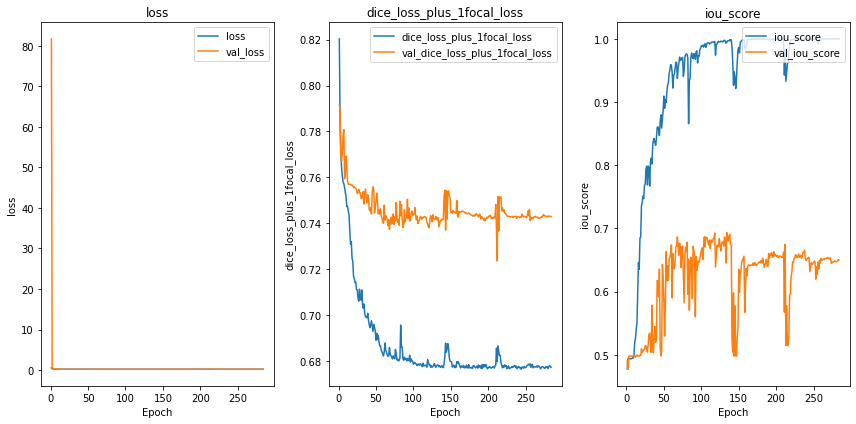

In [23]:
display_learning_curves(unet_history)

In [26]:
unet_model.load_weights(save_results)
y_pred1=unet_model.predict(X_val)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes) 
print(IOU_keras)
IOU_keras.update_state(val_mask[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)


Mean IoU = 0.7037706
[[  10213.    9872.]
 [   4787. 4742872.]]


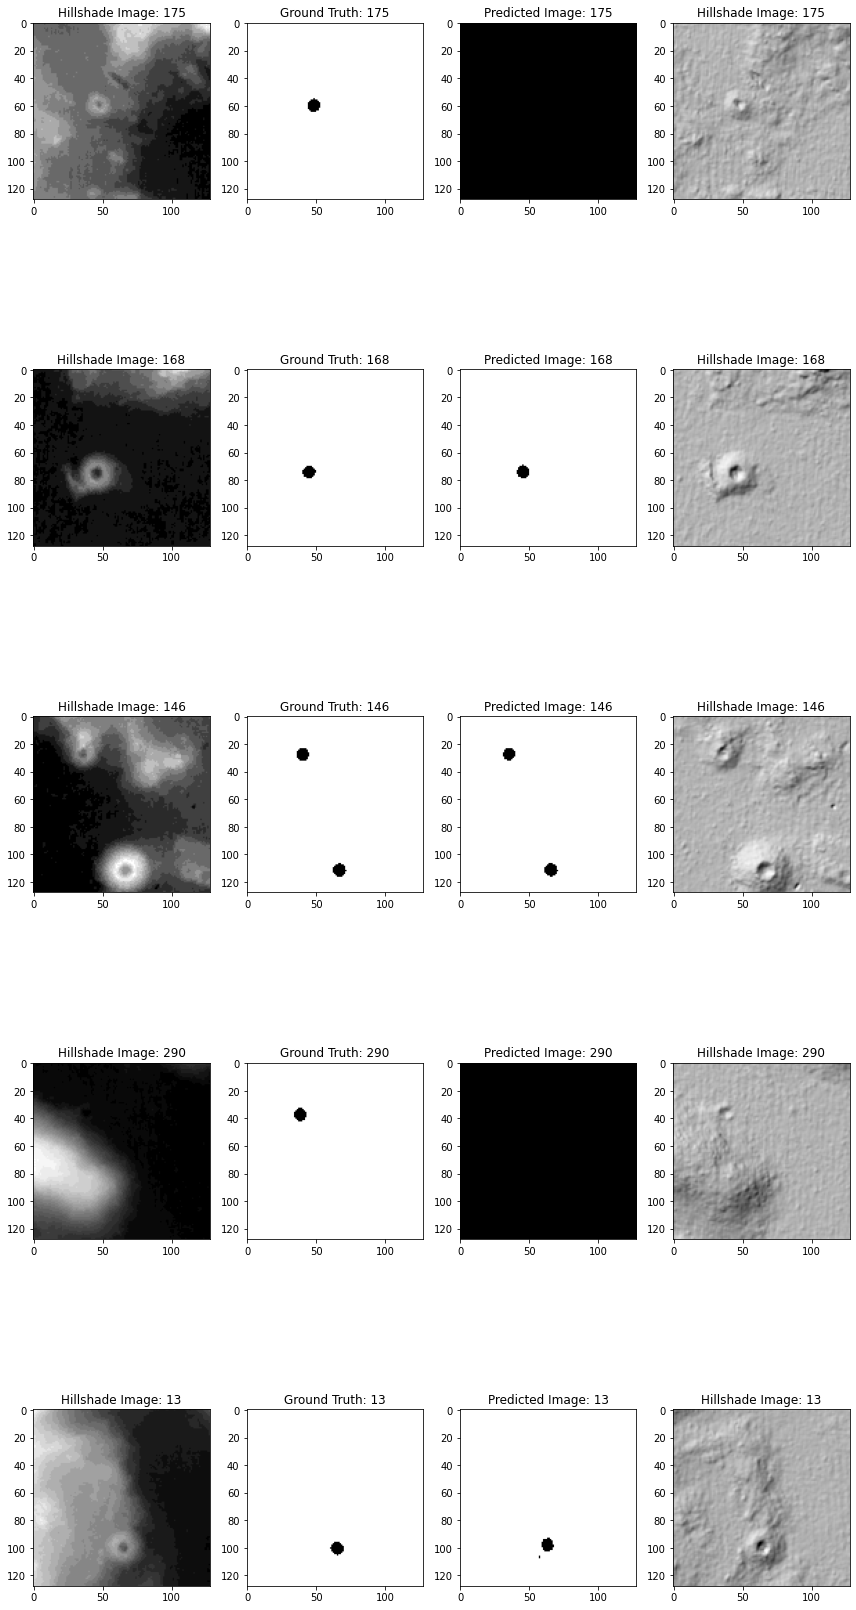

In [25]:
test_img = X_val
ground_truth=y_val_cat[:,:,:,1]
test_pred1 = unet_model.predict(test_img)
test_prediction1 = np.argmax(test_pred1, axis=3)

display_multiple_img(val_hill, test_img, ground_truth, test_prediction1, 'unet_plt_1', save_results, n=5)